In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### **Recurrent Neural Network**
### **Long Short Term Memory (LSTM) Model**

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) architecture designed to learn and remember long-term dependencies in sequential data, achieved through specialized memory cells and gating mechanisms. LSTMs are widely used in tasks like natural language processing, speech recognition, and time series prediction for their ability to effectively capture complex patterns over extended sequences.

In [4]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [5]:
# load the data
df = pd.read_csv(r'c:\Users\prita\Downloads\EV_ChargingData_Cleaned.csv')
df.head()

,Station Name,Start Date,End Date,Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Plug Type,Postal Code,Latitude,...,Ended By,Driver Postal Code,Park Duration (mins),Charge Duration (mins),Year,Month,Day,Hour,Weekday,Weekend
0,PALO ALTO CA / HAMILTON #1,2011-07-29 20:17:00,2011-07-29 23:20:00,6.249457,2.625,0.784,Level 2,J1772,94301,37.444572,...,Plug Out at Vehicle,95124.0,184.0,114.0,2011,7,29,20,4,0
1,PALO ALTO CA / HAMILTON #1,2011-07-30 00:00:00,2011-07-30 00:02:00,0.106588,0.045,0.013,Level 2,J1772,94301,37.444572,...,Customer,94301.0,2.0,2.0,2011,7,30,0,5,1
2,PALO ALTO CA / HAMILTON #1,2011-07-30 08:16:00,2011-07-30 12:34:00,14.951777,6.280,1.876,Level 2,J1772,94301,37.444572,...,Plug Out at Vehicle,94301.0,258.0,257.0,2011,7,30,8,5,1
3,PALO ALTO CA / HAMILTON #1,2011-07-30 14:51:00,2011-07-30 16:55:00,7.159643,3.007,0.899,Level 2,J1772,94301,37.444572,...,Customer,94302.0,123.0,123.0,2011,7,30,14,5,1
4,PALO ALTO CA / HAMILTON #1,2011-07-30 18:51:00,2011-07-30 20:03:00,1.957765,0.822,0.246,Level 2,J1772,94301,37.444572,...,Plug Out at Vehicle,94043.0,71.0,44.0,2011,7,30,18,5,1


In [6]:
# take start date and energy columns and convert them to pandas series
series = df[['Start Date', 'Energy (kWh)']]
series

,Start Date,Energy (kWh)
0,2011-07-29 20:17:00,6.249457
1,2011-07-30 00:00:00,0.106588
2,2011-07-30 08:16:00,14.951777
3,2011-07-30 14:51:00,7.159643
4,2011-07-30 18:51:00,1.957765
...,...,...
9994,2013-03-15 12:15:00,10.495324
9995,2013-03-15 12:23:00,8.055242
9996,2013-03-15 12:40:00,0.000043
9997,2013-03-15 12:46:00,6.599530


<Axes: ylabel='Energy (kWh)'>

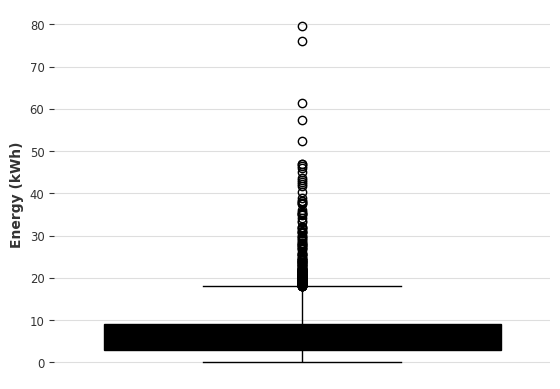

In [7]:
# box plot of energy consumption using seaborn
import seaborn as sns
sns.boxplot(y=series['Energy (kWh)'])


In [8]:
# get the no of observationa where energy consumption is greater than 20
series[series['Energy (kWh)'] > 20].count()

Start Date      130
Energy (kWh)    130
dtype: int64

In [9]:
# get the no of observations where energy consumption is 0  
series[series['Energy (kWh)'] == 0].count()

Start Date      0
Energy (kWh)    0
dtype: int64

In [10]:
# get the no of observations where energy consumption is less than 1
series[series['Energy (kWh)'] < 1].count()

Start Date      749
Energy (kWh)    749
dtype: int64

In [11]:
# remove outliers from the series
series = series[series['Energy (kWh)'] < 20]


In [12]:
# datatypes of the columns
series.dtypes

Start Date       object
Energy (kWh)    float64
dtype: object

In [13]:
# print first and last date of the series
print(series['Start Date'].min())
print(series['Start Date'].max())

2011-07-29 20:17:00
2013-03-15 13:44:00


In [14]:
# convert the start date to datetime
series['Start Date'] = pd.to_datetime(series['Start Date'])

In [15]:
# aggregate the data on daily basis
series1 = series.set_index('Start Date')
series_daily = series1.resample('D').sum()


In [16]:
#reset index
series_daily.reset_index(inplace=True)

In [17]:
series_daily.head()

,Start Date,Energy (kWh)
0,2011-07-29,6.249457
1,2011-07-30,28.978653
2,2011-07-31,37.209163
3,2011-08-01,5.041244
4,2011-08-02,16.210423


In [18]:
# convert to a timeseries series from dataframe
series_daily = TimeSeries.from_dataframe(series_daily, 'Start Date', 'Energy (kWh)')

<Axes: xlabel='Start Date'>

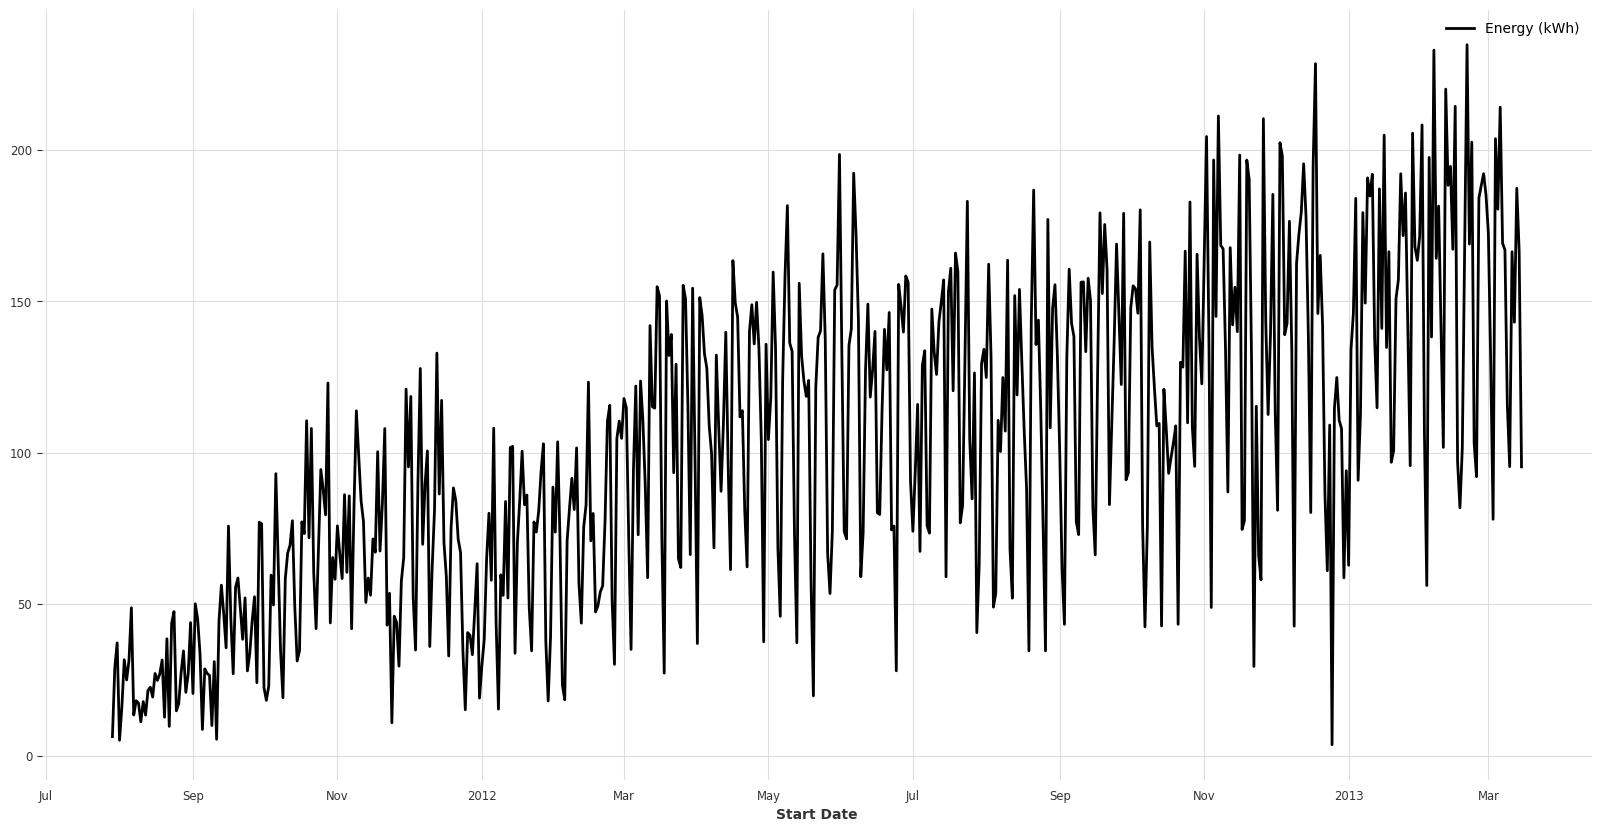

In [19]:
# plot the series with plot size 15,5
plt.figure(figsize=(20,10)) 
series_daily.plot()  

In [20]:
# Create training and validation sets:
train, val = series_daily.split_after(pd.Timestamp("20130115"))

In [21]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series_daily)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series_daily.start_time(), freq=series_daily.freq_str, periods=1000),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp("20130115")) # keeping last three months of data for validation/testing

In [23]:
#define RNN -LSTM model
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Energy_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
)

In [24]:
# fit the model
my_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

Epoch 199: 100%|██████████| 33/33 [00:01<00:00, 25.23it/s, v_num=logs, train_loss=0.00697, val_loss=0.074] 


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=20, batch_size=16, n_epochs=200, optimizer_kwargs={'lr': 0.001}, model_name=Energy_RNN, log_tensorboard=True, random_state=42, input_chunk_length=14, force_reset=True, save_checkpoints=True)

In [25]:
# function for evaluating the model and ploting actual and predicted series
def eval_model(model):
    pred_series = model.predict(n=60, future_covariates=covariates)
    plt.figure(figsize=(20, 10))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.26it/s]

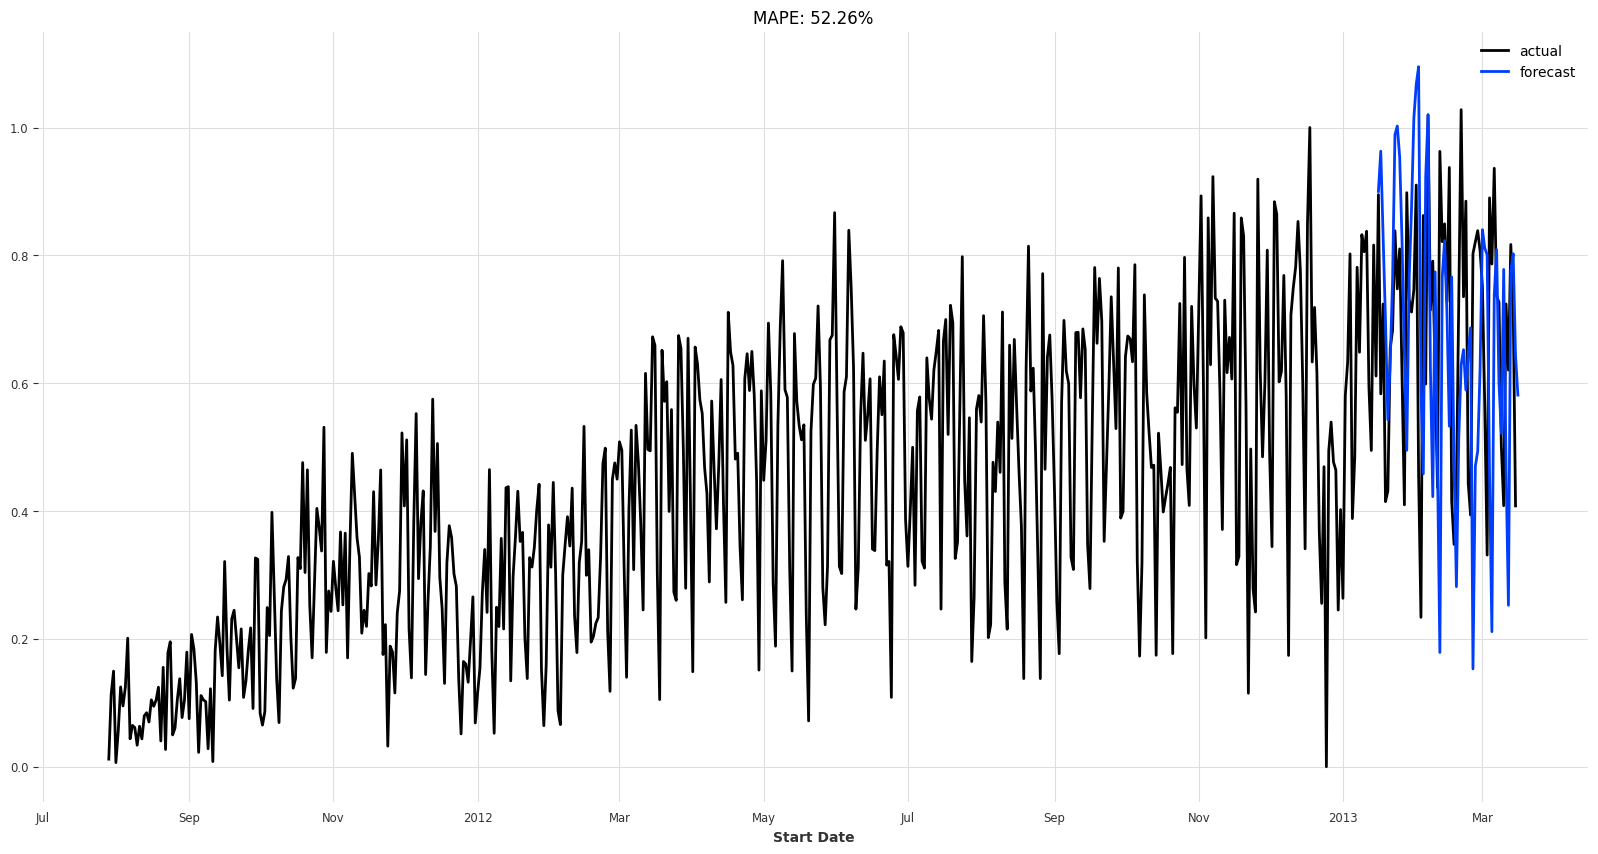

In [26]:
eval_model(my_model)

The LSTM model is giving Mean Absolute Percentage Error (MAPE) value of 52.26%, which is quite big as we didnt perform any hyperparameter tuning yet. But we can see that the forecasting is following the trend of actual series.

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


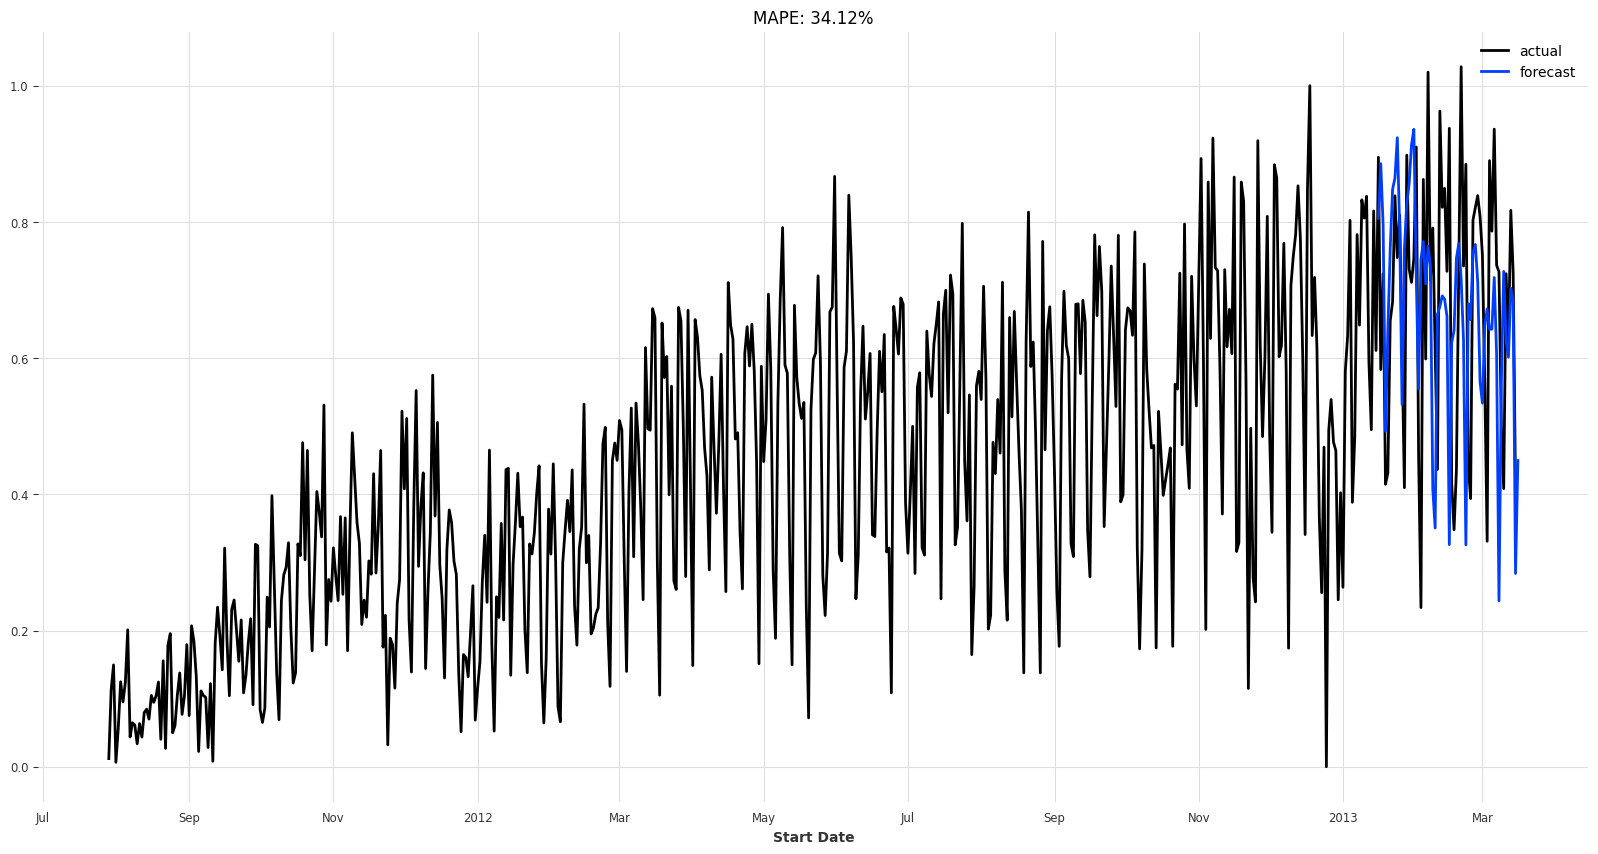

In [27]:
# getting the best model
best_model = RNNModel.load_from_checkpoint(model_name="Energy_RNN", best=True)
eval_model(best_model)

The best model is giving MAPE value of 34.12% which is good as compared to the previous one.

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.56it/s]

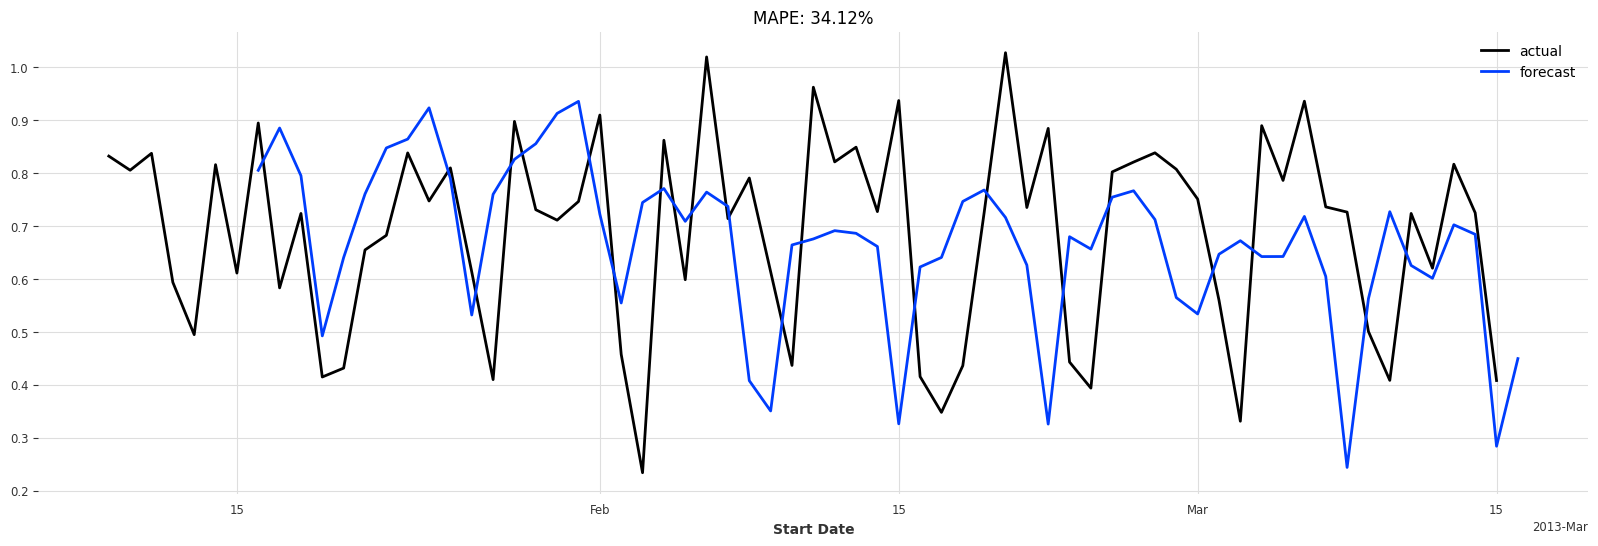

In [28]:
# plotting only the forecasted part of the series
plt.figure(figsize=(20, 6))
series_transformed[530:].plot(label="actual")
pred_series = best_model.predict(n=60, future_covariates=covariates)
pred_series.plot(label="forecast")
plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
plt.legend()

In [29]:
# create a backtest series and forecast using best model
backtest_series = best_model.historical_forecasts(
    series_transformed,
    future_covariates=covariates,
    start=pd.Timestamp("20130115"),
    forecast_horizon=3,
    retrain=False,
    verbose=True,
)

Predicting DataLoader 0:   0%|          | 0/4 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 13.67it/s]


MAPE: 22.03%


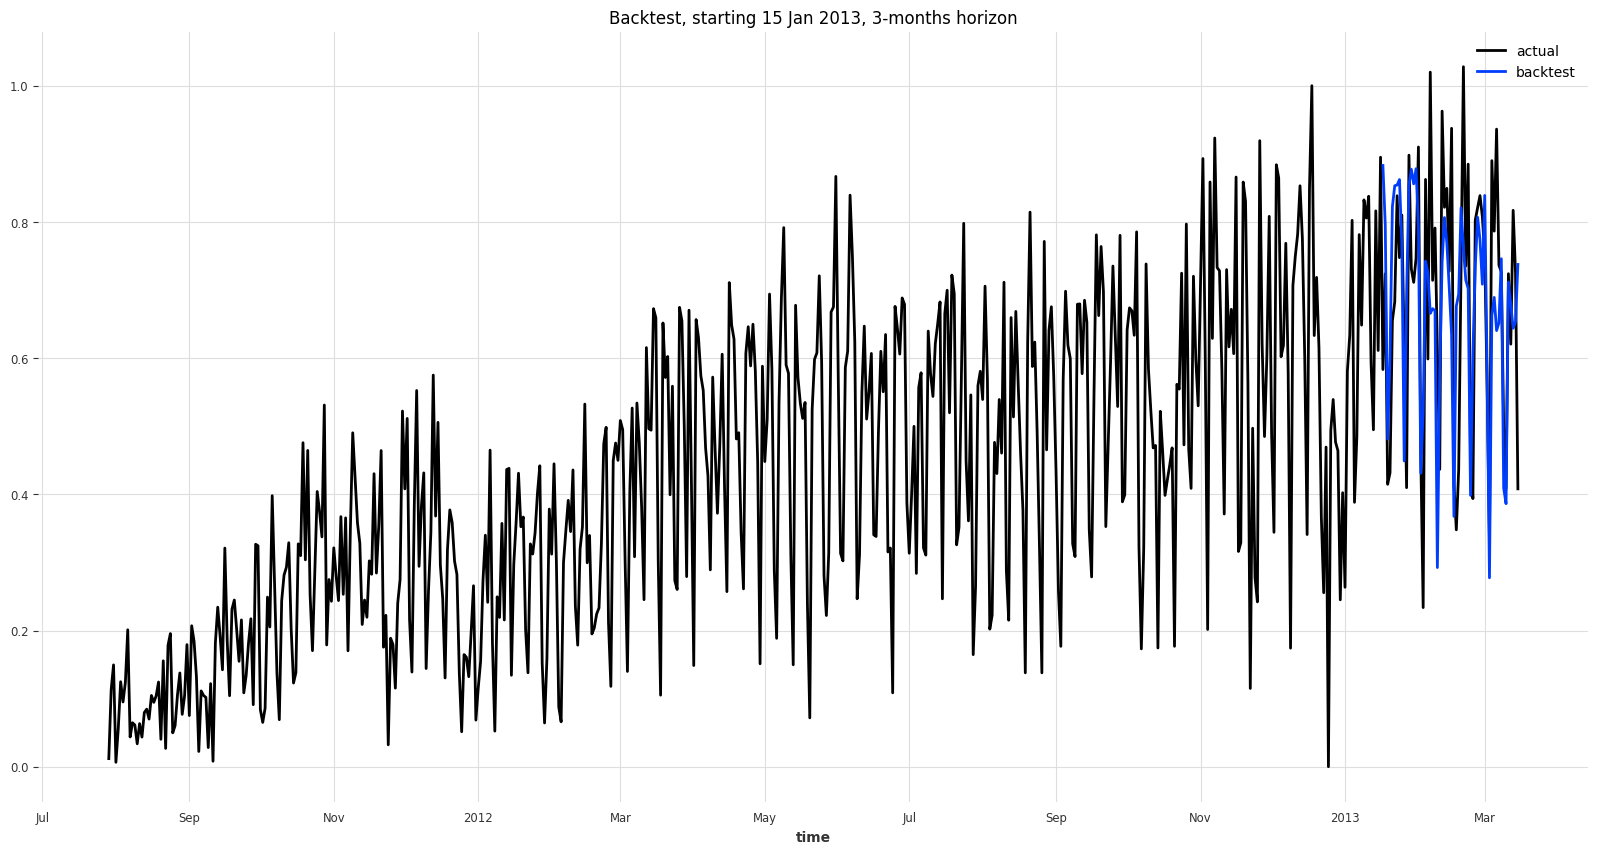

In [30]:
# plot the backtest prediction
plt.figure(figsize=(20, 10))
series_transformed.plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting 15 Jan 2013, 3-months horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

MAPE: 22.03%


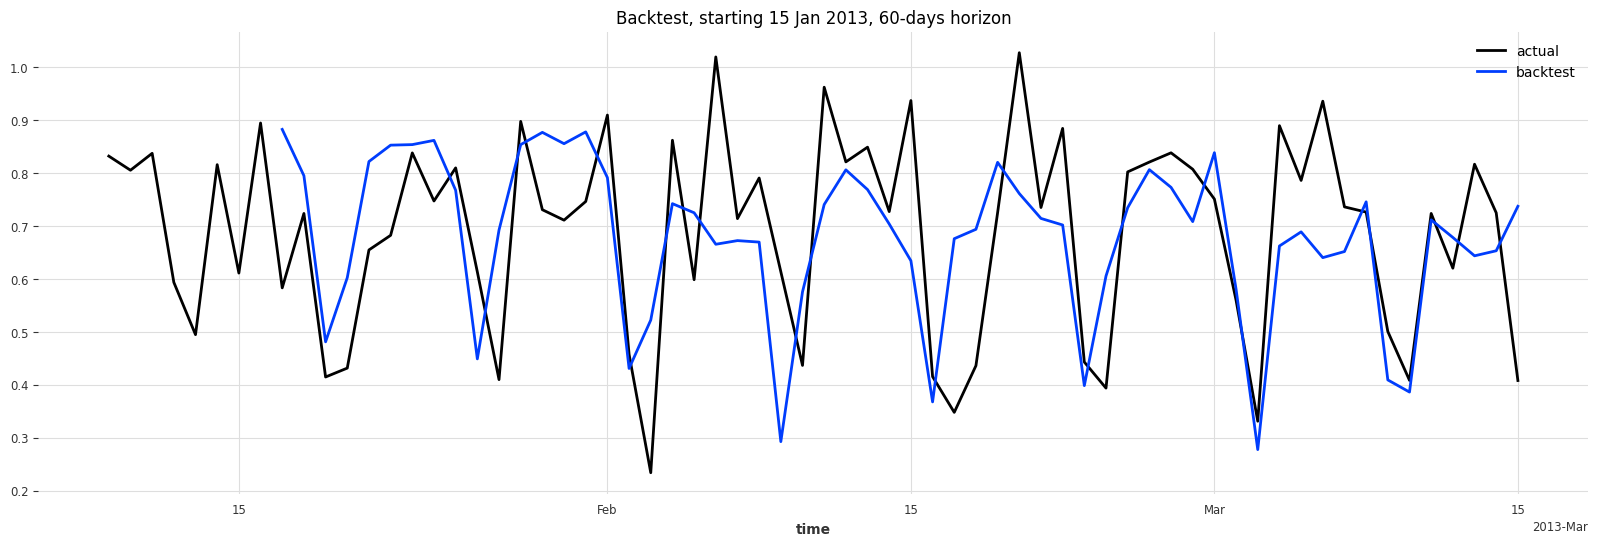

In [31]:
#closer look at the prediction and actual series
plt.figure(figsize=(20, 6))
series_transformed[530:].plot(label="actual")
backtest_series.plot(label="backtest")
plt.legend()
plt.title("Backtest, starting 15 Jan 2013, 60-days horizon")
print(
    "MAPE: {:.2f}%".format(
        mape(
            transformer.inverse_transform(series_transformed),
            transformer.inverse_transform(backtest_series),
        )
    )
)

The backtest model improves the accuracy of the model with 22.03% MAPE value and the graph shows the forecasting is following the proper trend of actual series. Hyperparameter tunning will improve the accuracy of the model.

### **Neural Basis Expansion Analysis Time Series Forecasting (NBEATS)**

The N-BEATS (Neural Basis Expansion Analysis for Time Series) model is a neural network architecture designed for time series forecasting, utilizing a stack of fully connected neural networks and interpretable basis functions. It decomposes time series data into a set of basis functions, enabling accurate predictions while maintaining interpretability, and has shown promising performance in various forecasting tasks.

In [1]:

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

C:\Users\prita\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# function to display forecasting
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(20, 10))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [32]:
# define the NBEATS model
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [33]:
# fit the model
model_nbeats.fit(train_transformed, val_series=val_transformed)

Epoch 99: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it, train_loss=0.0107, val_loss=0.0198]


NBEATSModel(generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x000001E60990B310>]})

In [34]:
# get the best model
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [47]:
# perform prediction
pred_series = model_nbeats.historical_forecasts(
    series_transformed,
    start=val.start_time(),
    forecast_horizon=8,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

In [48]:
pred_series = concatenate(pred_series, ignore_time_axis=True)

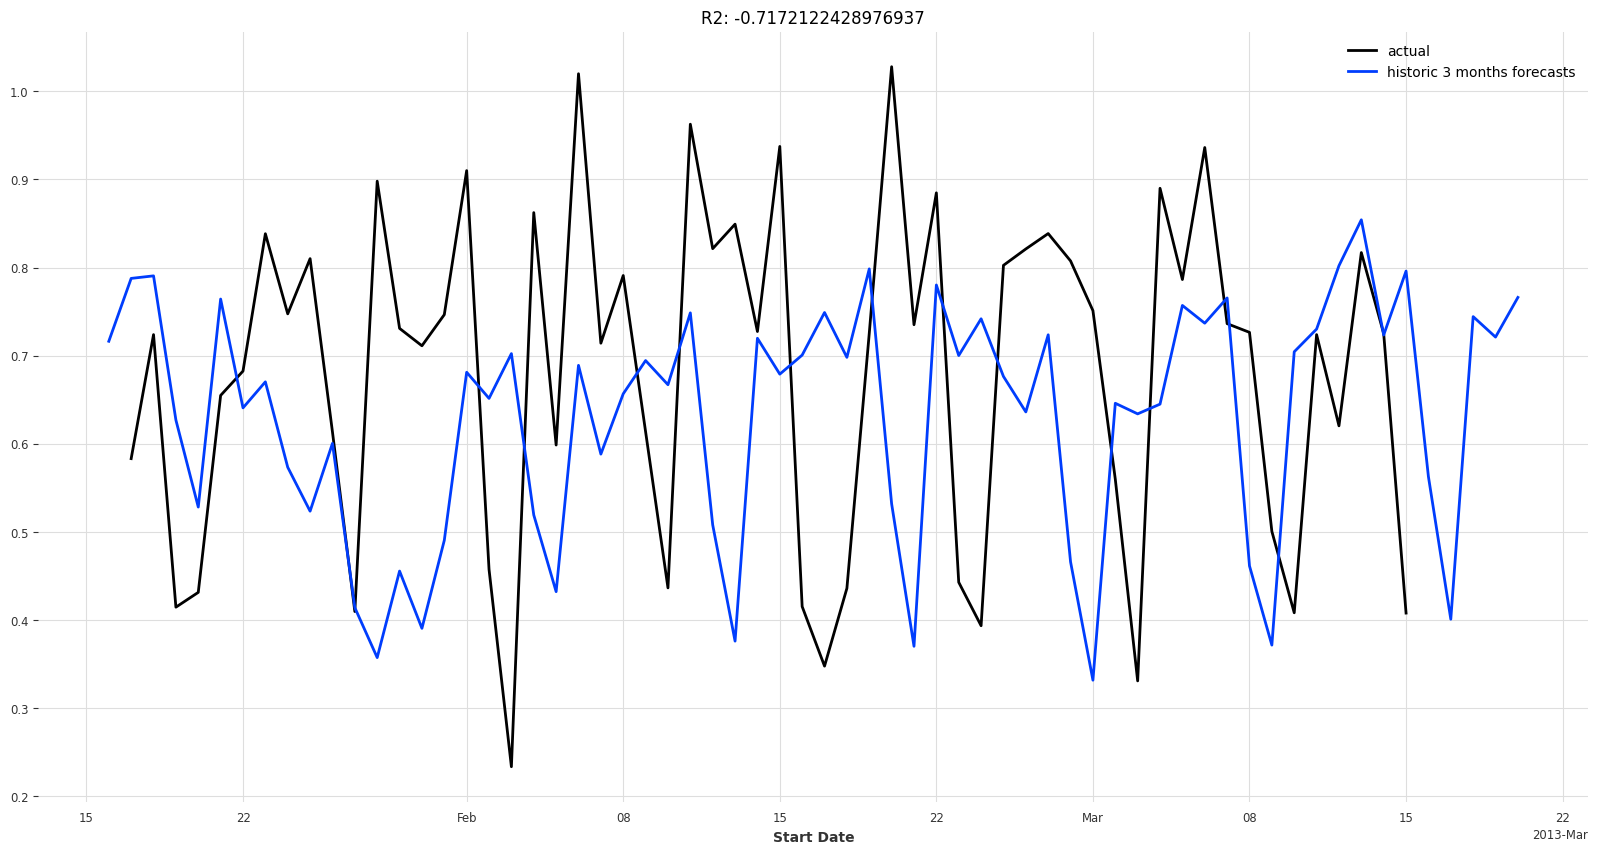

In [49]:
# plot forecasting
display_forecast(
    pred_series,
    series_transformed,
    "3 months",
    start_date=val.start_time(),
)

The R2 values shows that the model performs worse on the data, This could happen if the model is overfitting the data or if it's not capturing any meaningful relationship between the independent and dependent variables.

AS my data is a timeseries data, it is better to use deep learning models or statistical models to perform the forecasting on future timesteps instead of using the traditional machine learning models. There are various timeseries model specifically desingned for such task. I have implemented two of those. i will try to perform some hyperparameter tunning to check the performance.